<a href="https://colab.research.google.com/github/ReynaldoMR3/RL/blob/main/Self_Driving_Cab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 1: Self Driving Cab

The exercise of the Self Driving Cab belongs to Satwik Kansan and Brendan Martin.

You can find more about the exercise at:

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/



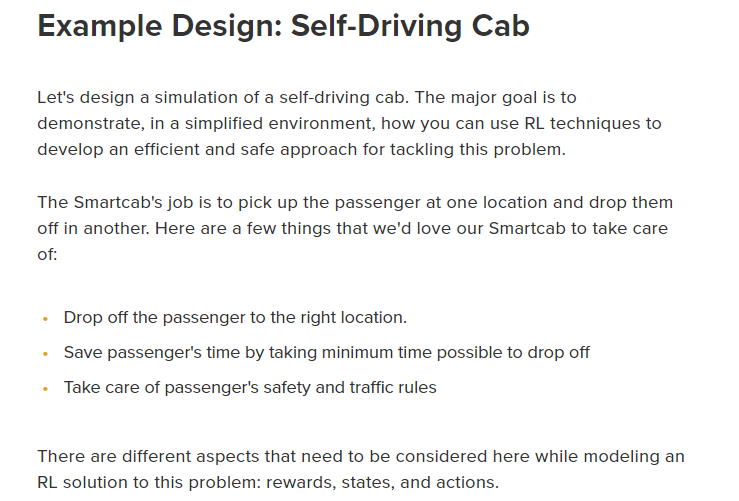

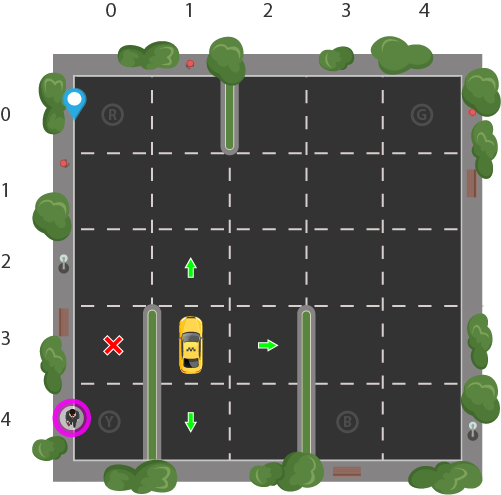

In [1]:
!pip install cmake 'gym[atari]' scipy

In [2]:
import gym

In [5]:
env = gym.make('Taxi-v3').env # load the taxi environment
env.render()                  # plot the environment
                              # env.reset() resets the environment and returns a random initial state
                              # env.step(action) Step the environment by one timestep. Returns:
                              # observation, reward, done, info.

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

The filled square represents the taxi, which is yellow without a passenger and green with a passenger.

The pipe ("|") represents a wall which the taxi cannot cross.


R, G, Y, B are the possible pickup and destination locations. 

The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

In [6]:
print(f"Action Space {env.action_space}")
print(f"State Space {env.observation_space}")

Action Space Discrete(6)
State Space Discrete(500)


In [7]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [8]:
state = env.encode(3, 4, 2, 0)     # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 388
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [10]:
env.P[388]    # we will use the state 388 that the env returned with the encoded state
              # returns a dictionary {action: [(probability, nextstate, reward, done)]}
              # env.action_space.sample() automatically selects one random action from set of all possible actions

{0: [(1.0, 488, -1, False)],
 1: [(1.0, 288, -1, False)],
 2: [(1.0, 388, -1, False)],
 3: [(1.0, 368, -1, False)],
 4: [(1.0, 388, -10, False)],
 5: [(1.0, 388, -10, False)]}

Solving the environment without Reinforcement Learning

In [12]:
env.s = 328                               # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
  action = env.action_space.sample()      # automatically selects one random action from set of all possible actions
  state, reward, done, info = env.step(action) 

  if reward == -10:
    penalties +=1

  # Put each rendered frame into dict for animation
  frames.append(
      {
      'frame' : env.render(mode='ansi'),  # returns a  terminal-style text representation. 
                                          # The text can include newlines and ANSI escape sequences (e.g. for colors).
      'state' : state,
      'action' : action,
      'reward' : reward
    }
  )

  epochs += 1


print(f"Timesteps taken: {epochs}")
print(f"Penalties incurred: {penalties}")

Timesteps taken: 573
Penalties incurred: 190


In [24]:
for i, frame in enumerate(frames):
  print(frame['frame'])
  break

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



In [26]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
  for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(frame['frame'])
    print(f"Timestep: {i + 1}")
    print(f"State: {frame['state']}")
    print(f"Action: {frame['action']}")
    print(f"Reward: {frame['reward']}")
    sleep(.1)

print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 573
State: 0
Action: 5
Reward: 20


Not good. Our agent takes thousands of timesteps and makes lots of wrong drop offs to deliver just one passenger to the right destination.

This is because we aren't learning from past experience. We can run this over and over, and it will never optimize. The agent has no memory of which action was best for each state, which is exactly what Reinforcement Learning will do for us.

This is why we need to introduce reinforcement learning and the first algorithm that we will see is called Q-learning.

It does thing by looking receiving a reward for taking an action in the current state, then updating a Q-value to remember if that action was beneficial.

The values store in the Q-table are called a Q-values, and they map to a (state, action) combination.

A Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. Better Q-values imply better chances of getting greater rewards.

For example, if the taxi is faced with a state that includes a passenger at its current location, it is highly likely that the Q-value for pickup is higher when compared to other actions, like dropoff or north.

Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

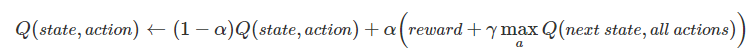

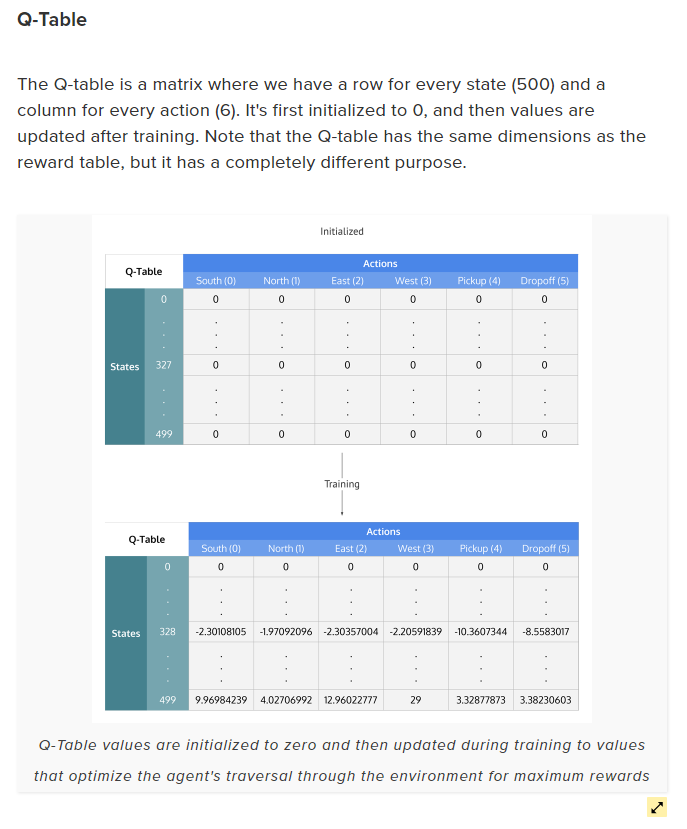

In [28]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])    #500 rows, 6 columns (states, actions)

In [35]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1     # learning rate
gamma = 0.6     # discount factor
epsilon = 0.1   # favors exploration instead of explotation

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100_001):
  state = env.reset()

  epochs, penalties, reward = 0, 0, 0
  done = False

  while not done:
    if random.uniform(0, 1) < epsilon:      #pick a random action instead or exploit the already computed Q-values
      action = env.action_space.sample() # Explore action space
    else:
      action = np.argmax(q_table[state]) # Explot learned values

    next_state, reward, done, info = env.step(action)   # example: (20, -1, False, {'prob': 1.0})

    old_value = q_table[state, action]
    next_max = np.max(q_table[next_state])

    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
    q_table[state, action] = new_value

    if reward == -10:
      penalties += 1

    state = next_state
    epochs += 1

    if i % 100 == 0:
      clear_output(wait=True)
      print(f"Episode: {i}")


print("Training finished. \n")

Episode: 100000
Training finished. 

CPU times: user 2min 6s, sys: 7.37 s, total: 2min 14s
Wall time: 3min 20s


In [39]:
print(f"State: {env.s}")
env.render() # lets see the state of the taxi cab

State: 85
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [40]:
q_table[85] # let's see what the Q-values are at our illustration's state

array([0., 0., 0., 0., 0., 0.])

Let's evaluate the performance of our agent. We don't need to explore actions any further, so now the next action is always selected using the best Q-value

In [41]:
"""Evaluate agent's performance after Q-learning"""
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
  state = env.reset()
  epochs, penalties, rewards = 0, 0, 0

  done = False

  while not done:
    action = np.argmax(q_table[state]) # explotation, we dont need exploration anymore
    state, reward, done, info = env.step(action)

    if reward == - 10:
      penalties += 1
    
    epochs += 1

    total_penalties += penalties
    total_epochs += epochs


print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 86.68
Average penalties per episode: 0.0


We can see from the evaluation, the agent's performance improved significantly and it incurred no penalties, which means it performed the correct pickup/dropoff actions with 100 different passengers.

Hyperparameters and optimizations
The values of `alpha`, `gamma`, and `epsilon` were mostly based on intuition and some "hit and trial", but there are better ways to come up with good values.

Ideally, all three should decrease over time because as the agent continues to learn, it actually builds up more resilient priors

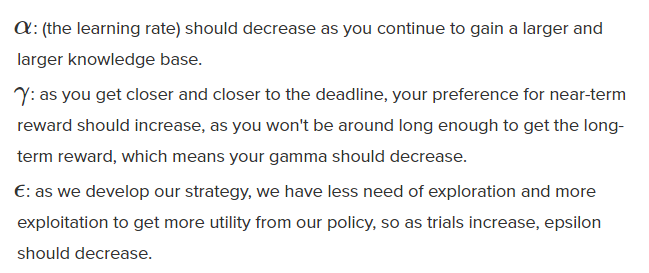